<a href="https://colab.research.google.com/github/phelipe-sb/Rain-Prediction/blob/main/Exploratory_Analisis_and_Data_Transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Get Data from BigQuery**

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import numpy as np
import pandas as pd

In [2]:
# Projett credentials with account service
path = '/content/drive/MyDrive/Weather_Project/Weather Project-6fa8e059f642.json'

In [3]:
# Credentials
credentials = service_account.Credentials.from_service_account_file(path)
project_id = credentials.project_id
client = bigquery.Client(project=project_id, credentials=credentials)

In [4]:
# SQL Query that will run in BQ
query_string = """
SELECT *
FROM (SELECT *
            , ROW_NUMBER() OVER(PARTITION BY last_updated, city ORDER BY last_updated, city) AS row_num
            FROM `weather-project-305419.Daily_Weather.Weather-Info`) as row_weather
WHERE row_num = 1
"""

In [5]:
# Transform sql query results in a pandas dataframe
df = (
    client.query(query_string)
    .result()
    .to_dataframe()
)
df.head()

,last_updated_epoch,last_updated,temp_c,temp_f,is_day,condition,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feelslike_c,feelslike_f,vis_km,vis_miles,uv,gust_mph,gust_kph,city,extraction_date,row_num
0,1619162100,2021-04-23 04:15,13.9,57.0,0,Partly cloudy,5.4,8.6,153,SSE,1018.0,30.5,0.0,0.0,91,48,13.5,56.3,10.0,6.0,1.0,8.7,14.0,Carapicuiba,None,1
1,1619244900,2021-04-24 03:15,18.4,65.1,0,Partly cloudy,5.6,9.0,129,SE,1017.0,30.5,0.0,0.0,79,43,18.4,65.1,10.0,6.0,1.0,6.5,10.4,Sao Paulo,None,1
2,1619249400,2021-04-24 04:30,18.5,65.3,0,Partly cloudy,5.4,8.6,122,ESE,1016.0,30.5,0.0,0.0,78,49,18.5,65.3,10.0,6.0,1.0,6.0,9.7,Sao Paulo,None,1
3,1619270100,2021-04-24 09:15,13.9,57.0,1,Sunny,5.6,9.0,320,NW,1018.0,30.5,0.0,0.0,34,0,13.3,55.9,16.0,9.0,1.0,8.1,13.0,New York,None,1
4,1619308800,2021-04-25 02:00,10.2,50.4,0,Partly cloudy,9.8,15.8,43,NE,1023.0,30.7,0.0,0.0,65,31,8.1,46.6,10.0,6.0,1.0,13.4,21.6,Paris,None,1


In [6]:
%cd /content/drive/MyDrive/Weather_Project

/content/drive/MyDrive/Weather_Project


In [7]:
# Saving in a pickle file so we don't need query in database again
import pickle
df.to_pickle("weather_data")

### **2. Data Transformation**

In [8]:
# Open pickle file
file = open('/content/drive/MyDrive/Weather_Project/weather_data', 'rb')
df = pickle.load(file)

In [9]:
cidades = ['Paris', 'Sao Paulo', 'Carapicuiba', 'New York', 'Otawwa', 'London', 'Rome', 'Moscow'
        , 'Hong Kong', 'Beijing']
df = df.loc[df['city'].isin(cidades)]
df['last_updated'] = pd.to_datetime(df['last_updated'])
df.shape

(53702, 26)

In [10]:
# Drop useless columns for analysis
df = df.drop(columns=['row_num', 'last_updated_epoch', 'extraction_date'])
df = df.dropna()
# number of rows and columns
print(df.shape, df['city'].unique())

(53702, 23) ['Carapicuiba' 'Sao Paulo' 'New York' 'Paris' 'Hong Kong' 'Rome' 'Moscow'
 'London' 'Beijing']


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# Target: Predict condition (that means wether is raining or not) 
df['condition'].unique()

array(['Partly cloudy', 'Sunny', 'Light rain', 'Patchy rain possible',
       'Overcast', 'Mist', 'Light rain shower', 'Clear', 'Cloudy',
       'Patchy light rain with thunder', 'Thundery outbreaks possible',
       'Heavy rain', 'Light drizzle', 'Fog', 'Moderate rain',
       'Moderate rain at times', 'Moderate or heavy rain shower',
       'Torrential rain shower', 'Patchy light rain', 'Light snow',
       'Moderate or heavy rain with thunder',
       'Moderate or heavy snow with thunder',
       'Moderate or heavy snow showers', 'Heavy rain at times',
       'Ice pellets'], dtype=object)

We need to resume this bunch of conditions and define our target class

In [13]:
# This conditions means that it's raining in the moment
raining_list = ['Light rain', 'Light rain shower', 'Light drizzle', 'Heavy rain', 'Moderate rain', 'Patchy light rain with thunder'
            , 'Moderate or heavy rain shower', 'Patchy light rain', 'Torrential rain shower', 'Moderate rain at times'
            , 'Moderate or heavy rain with thunder']

In [14]:
# Creating the target variable
df['target'] = df['condition'].apply(lambda x: 1 if x in raining_list else 0)
df['target'].unique()

array([0, 1])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53702 entries, 0 to 55605
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   last_updated  53702 non-null  datetime64[ns]
 1   temp_c        53702 non-null  object        
 2   temp_f        53702 non-null  object        
 3   is_day        53702 non-null  object        
 4   condition     53702 non-null  object        
 5   wind_mph      53702 non-null  object        
 6   wind_kph      53702 non-null  object        
 7   wind_degree   53702 non-null  object        
 8   wind_dir      53702 non-null  object        
 9   pressure_mb   53702 non-null  object        
 10  pressure_in   53702 non-null  object        
 11  precip_mm     53702 non-null  object        
 12  precip_in     53702 non-null  object        
 13  humidity      53702 non-null  object        
 14  cloud         53702 non-null  object        
 15  feelslike_c   53702 non-null  object

In [16]:
# Create a list with columns to be converted
float_list = list()
for column_name in df.drop(columns='target').columns:
  if str(df[f'{column_name}'][0]).replace(".", "").replace("-", "").isnumeric() == True:
    float_list.append(column_name)

In [17]:
# function to convert columns to float
def to_float(df):
  for column in df.columns:
    if column in float_list:
      df[f'{column}'] = df[f'{column}'].astype("float")
  return df.info()

In [18]:
to_float(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53702 entries, 0 to 55605
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   last_updated  53702 non-null  datetime64[ns]
 1   temp_c        53702 non-null  float64       
 2   temp_f        53702 non-null  float64       
 3   is_day        53702 non-null  float64       
 4   condition     53702 non-null  object        
 5   wind_mph      53702 non-null  float64       
 6   wind_kph      53702 non-null  float64       
 7   wind_degree   53702 non-null  float64       
 8   wind_dir      53702 non-null  object        
 9   pressure_mb   53702 non-null  float64       
 10  pressure_in   53702 non-null  float64       
 11  precip_mm     53702 non-null  float64       
 12  precip_in     53702 non-null  float64       
 13  humidity      53702 non-null  float64       
 14  cloud         53702 non-null  float64       
 15  feelslike_c   53702 non-null  float6

### **3. Data Analysis**

percentage of target == 1 is: 10.0%


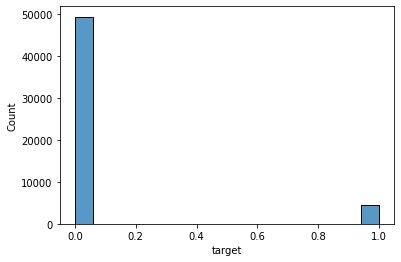

In [19]:
# Target Variable Ocurrency
percent = str(round(sum(df['target'])/len(df['target']), 1)*100) + '%'
print(f'percentage of target == 1 is: {percent}')
sns.histplot(data=df['target'])

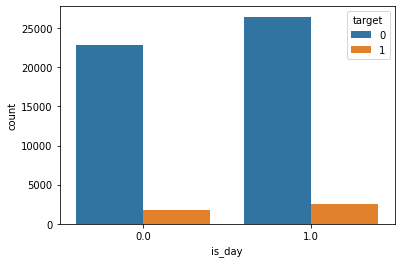

In [20]:
sns.countplot(x=df['is_day'], hue=df['target'])

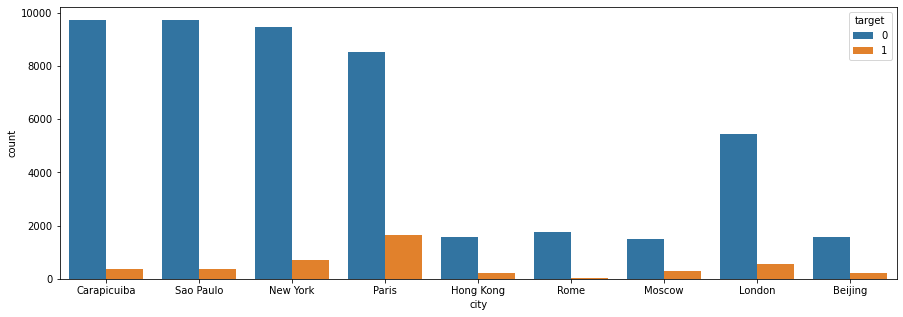

In [21]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x=df['city'], hue=df['target'])

<Figure size 720x360 with 0 Axes>

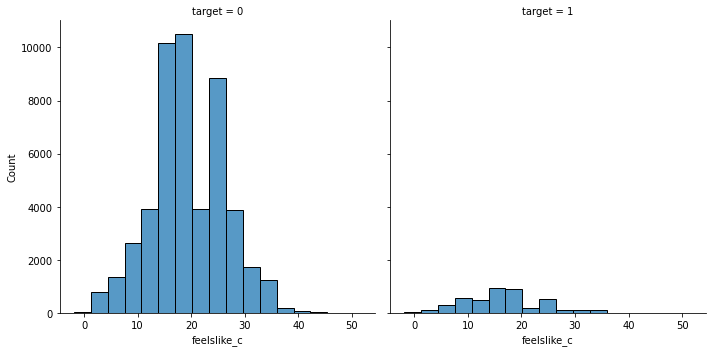

In [22]:
plt.figure(figsize=(10, 5))
ax = sns.displot(x=df['feelslike_c'], bins='sturges', col=df['target'])

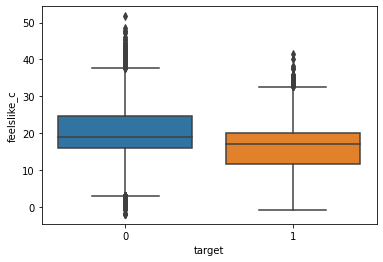

In [23]:
sns.boxplot(x=df['target'], y=df['feelslike_c'])

<Figure size 720x360 with 0 Axes>

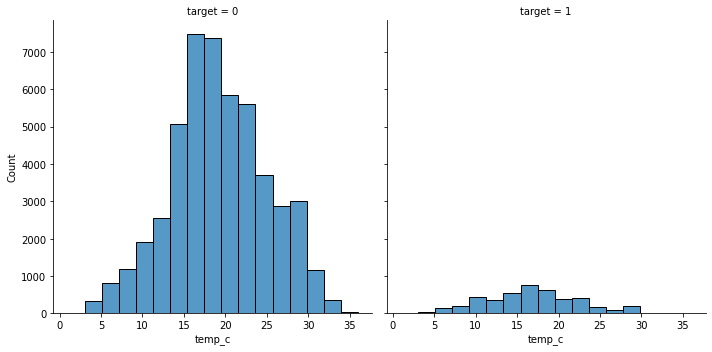

In [24]:
plt.figure(figsize=(10, 5))
ax = sns.displot(x=df['temp_c'], bins='sturges', col=df['target'])

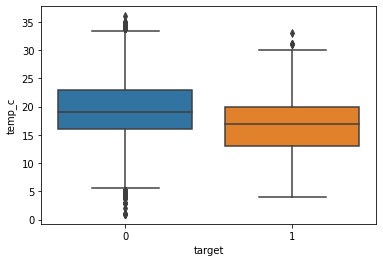

In [25]:
sns.boxplot(x=df['target'], y=df['temp_c'])

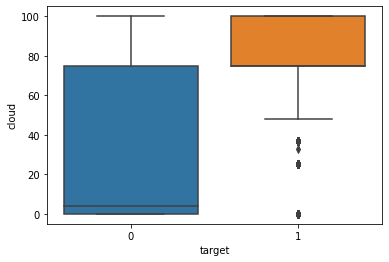

In [26]:
sns.boxplot(x=df['target'], y=df['cloud'])

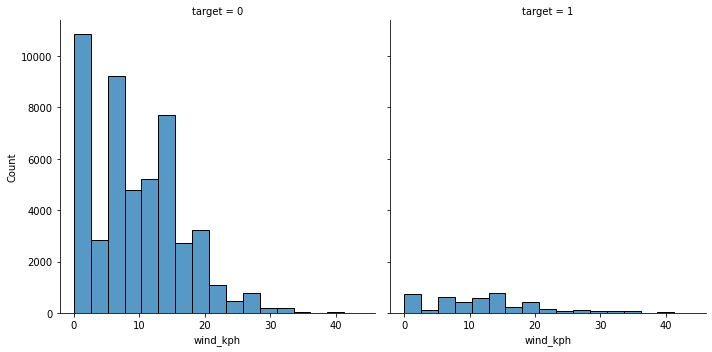

In [27]:
sns.displot(x=df['wind_kph'], col=df['target'], bins='sturges')

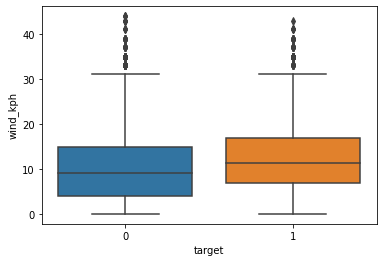

In [28]:
sns.boxplot(x=df['target'], y=df['wind_kph'])

In [29]:
df.describe()

,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feelslike_c,feelslike_f,vis_km,vis_miles,uv,gust_mph,gust_kph,target
count,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000
mean,19.054827,66.298866,0.540352,5.938853,9.550330,155.589364,1017.466314,30.306288,0.281619,0.010898,68.695672,35.766657,19.284906,66.708707,10.428375,6.093572,3.329448,8.976224,14.444712,0.081915
std,5.699556,10.259258,0.498374,4.504499,7.257404,104.572549,6.080144,0.308978,1.617836,0.063738,18.224215,38.514937,6.847045,12.325199,2.780176,1.610234,2.442270,4.508642,7.255767,0.274238
min,1.000000,33.800000,0.000000,0.000000,0.000000,0.000000,994.000000,29.380000,0.000000,0.000000,8.000000,0.000000,-1.900000,28.700000,0.000000,0.000000,1.000000,0.200000,0.400000,0.000000
25%,15.000000,59.000000,0.000000,2.500000,4.000000,70.000000,1014.000000,30.060000,0.000000,0.000000,56.000000,0.000000,15.500000,59.900000,10.000000,6.000000,1.000000,5.600000,9.000000,0.000000
50%,19.000000,66.200000,1.000000,5.600000,9.000000,140.000000,1018.000000,30.300000,0.000000,0.000000,72.000000,22.000000,19.000000,66.200000,10.000000,6.000000,3.000000,8.500000,13.700000,0.000000
75%,23.000000,73.400000,1.000000,9.400000,15.100000,240.000000,1022.000000,30.600000,0.100000,0.000000,83.000000,75.000000,24.600000,76.300000,10.000000,6.000000,6.000000,11.600000,18.700000,0.000000
max,36.000000,96.800000,1.000000,27.300000,43.900000,360.000000,1035.000000,31.000000,113.800000,4.480000,100.000000,100.000000,51.700000,125.100000,16.000000,9.000000,9.000000,41.600000,67.000000,1.000000


### **4. Modeling DataSet for MachineLearning Algorithm**

In [30]:
# Our goal is to predict weather is going to rain or not based on the last register
# Now we're going to split the data
train_df = df[['last_updated', 'city', 'temp_c', 'is_day', 'condition', 'wind_kph', 'wind_degree'
          , 'pressure_mb', 'precip_mm', 'humidity', 'cloud', 'feelslike_c', 'vis_km', 'uv'
          , 'gust_kph', 'target']]

In [31]:
train_df = train_df.sort_values(by=['city', 'last_updated']).reset_index().drop(columns='index')

In [32]:
train_df

,last_updated,city,temp_c,is_day,condition,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,target
0,2021-08-12 11:30:00,Beijing,27.0,1.0,Partly cloudy,6.8,140.0,1013.0,1.5,70.0,25.0,31.6,10.0,5.0,5.0,0
1,2021-08-27 08:00:00,Beijing,18.6,1.0,Partly cloudy,6.5,2.0,1011.0,0.0,62.0,9.0,18.6,10.0,5.0,11.9,0
2,2021-08-28 10:15:00,Beijing,21.0,1.0,Light rain,19.1,280.0,1015.0,0.0,73.0,0.0,21.0,10.0,6.0,8.6,1
3,2021-08-28 10:30:00,Beijing,21.0,1.0,Light rain,19.1,280.0,1015.0,0.0,73.0,0.0,21.0,10.0,6.0,8.6,1
4,2021-08-28 20:15:00,Beijing,21.0,0.0,Clear,0.0,221.0,1012.0,0.3,83.0,0.0,21.0,10.0,5.0,9.7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53697,2021-09-20 21:30:00,Sao Paulo,24.0,0.0,Clear,4.0,230.0,1014.0,0.0,54.0,0.0,25.0,10.0,8.0,13.7,0
53698,2021-09-20 21:45:00,Sao Paulo,24.0,0.0,Clear,4.0,230.0,1014.0,0.0,54.0,0.0,25.0,10.0,8.0,13.7,0
53699,2021-09-20 22:15:00,Sao Paulo,25.0,0.0,Clear,6.8,130.0,1016.0,0.0,65.0,0.0,25.8,10.0,1.0,9.0,0
53700,2021-09-20 22:30:00,Sao Paulo,25.0,0.0,Clear,6.8,130.0,1016.0,0.0,65.0,0.0,25.8,10.0,1.0,9.0,0


In [33]:
# Calculate the difference between the actual and previous register
def date_diff_calc(df_column):
  i = 1
  date_diff_list = list()
  for cell in df_column:
    if i < len(df_column):
      date_diff_min = (df_column[i] - cell).total_seconds()/60
      date_diff_list.append(date_diff_min)
      i += 1
  return date_diff_list

In [34]:
train_df['date_diff'] = pd.DataFrame(date_diff_calc(train_df['last_updated']))

In [35]:
# create a column that tells us weather is raining in the next 15 minutes
def rain_next1(df_column):
  i = 1
  rain_next1 = list()
  for cell in df_column:
    if i < len(df_column):
      rain_next1.append(df_column[i])
      i += 1
  return rain_next1

In [36]:
train_df['target_1'] = pd.DataFrame(rain_next1(train_df['target']))

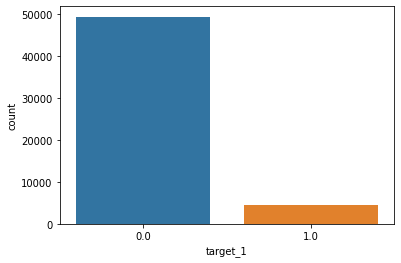

In [37]:
sns.countplot(x=train_df['target_1'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


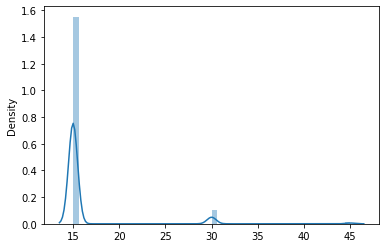

In [38]:
sns.distplot(x=train_df['date_diff'].loc[train_df['date_diff'] > -50].loc[train_df['date_diff'] < 50])

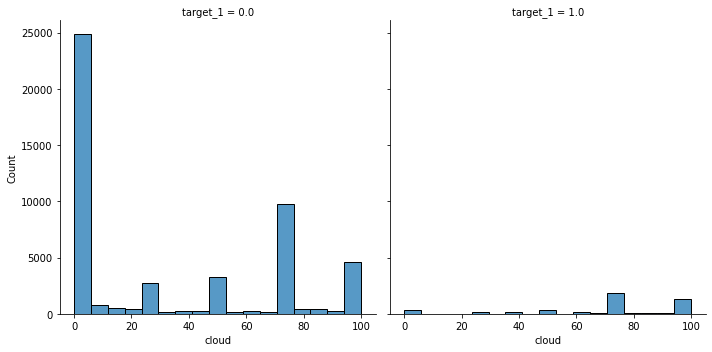

In [39]:
sns.displot(x=train_df['cloud'], col=train_df['target_1'], bins='sturges')

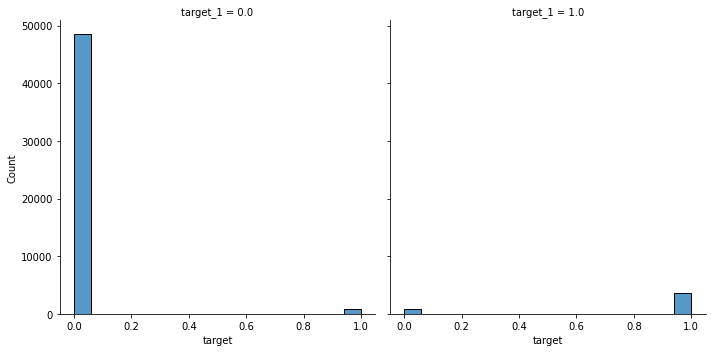

In [40]:
sns.displot(x=train_df['target'], col=train_df['target_1'], bins='sturges')

In [44]:
train_df = train_df.drop(columns='date_diff')
train_df.corr()

,temp_c,is_day,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,target,target_1
temp_c,1.000000,0.174237,-0.202346,-0.020789,-0.041089,-0.018734,-0.393324,-0.183912,0.986890,0.222629,0.567789,-0.115000,-0.115798,-0.109510
is_day,0.174237,1.000000,0.115568,0.062114,-0.014697,-0.015902,-0.257341,0.049009,0.161973,0.033896,0.346957,-0.046764,0.025886,0.025472
wind_kph,-0.202346,0.115568,1.000000,0.156666,-0.133222,-0.008062,-0.023349,0.192050,-0.216409,-0.278235,0.047471,0.481316,0.099668,0.095984
wind_degree,-0.020789,0.062114,0.156666,1.000000,-0.200600,0.032165,-0.124236,-0.021326,-0.036144,0.028296,0.074771,0.111388,0.071362,0.068281
pressure_mb,-0.041089,-0.014697,-0.133222,-0.200600,1.000000,-0.133644,-0.047219,-0.008144,-0.043073,0.030032,-0.011666,-0.260151,-0.225709,-0.224974
precip_mm,-0.018734,-0.015902,-0.008062,0.032165,-0.133644,1.000000,0.146512,0.153589,-0.009769,-0.044115,-0.046207,0.164227,0.197852,0.188135
humidity,-0.393324,-0.257341,-0.023349,-0.124236,-0.047219,0.146512,1.000000,0.429389,-0.331027,-0.334847,-0.524934,0.021105,0.250285,0.236449
cloud,-0.183912,0.049009,0.192050,-0.021326,-0.008144,0.153589,0.429389,1.000000,-0.163750,-0.153160,-0.158078,0.252196,0.301085,0.280651
feelslike_c,0.986890,0.161973,-0.216409,-0.036144,-0.043073,-0.009769,-0.331027,-0.163750,1.000000,0.211550,0.522620,-0.129934,-0.112271,-0.105538
vis_km,0.222629,0.033896,-0.278235,0.028296,0.030032,-0.044115,-0.334847,-0.153160,0.211550,1.000000,0.132179,0.140398,-0.229878,-0.208019


In [45]:
train_df.shape

(53702, 17)

In [ ]:
from 